# Get depth-weighted ratio of deep to shallow OHU 
## input: area-weighted global annual mean

Created May 13 2025

Begin further down if data already imported

$$OHC=\rho c_p(hT(t)+H T_d(t))$$
$$OHU=\frac{dOHC}{dt}=\rho c_p \left( h\frac{dT(t)}{dt}+H\frac{dT_d(t)}{dt} \right)$$
$$\text{Ratio = deep / shallow: } \frac{H\frac{dT_d(t)}{dt}}{h\frac{dT(t)}{dt}}$$


In [1]:
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm
import netCDF4

import matplotlib.pyplot as plt
from solar_func import find_and_open_xarray_file

plt.style.use('../func/paper.mplstyle')

In [2]:
# import sys
# if '/tigress/wenchang/wython' not in sys.path:
#     sys.path.append('/tigress/wenchang/wython')
    
# from misc.modelout import get_modelout_data, get_modelout_files

import sys
if '/tigress/wenchang/wython/' not in sys.path:
    sys.path.append('/tigress/wenchang/wython/')
    
from modelout.modelout import get_modelout_data, get_modelout_files

# Load data from experiments & compute global mean

In [3]:
def get_exps_latlon(model):

    # FLOR
    if model == 'FLOR':
        dsname = 'ocean'
        
        ## specify experiments
        exps = ['p1p0sol_CTL1860','m1p0sol_CTL1860','p2p0sol_CTL1860','m2p0sol_CTL1860',
                  'p4p0sol_CTL1860','m4p0sol_CTL1860','p6p0sol_CTL1860','m6p0sol_CTL1860']#,'CTL1860_newdiag']#['CTL1860_newdiag'] 
        
        extension = 'tigercpu_intelmpi_18_576PE'
        
        latname = 'yt_ocean'#'yt_ocean'
        lonname = 'xt_ocean'#'xt_ocean'
        
        #CTRL: ['CTL1860_newdiag']
    #     ['p1p0sol_CTL1860','m1p0sol_CTL1860','p2p0sol_CTL1860','m2p0sol_CTL1860',
    #              'p4p0sol_CTL1860','m4p0sol_CTL1860','p6p0sol_CTL1860','m6p0sol_CTL1860']

    # CM2.1
    if model == 'CM2.1p1':
        dsname = 'ocean_month'
        
        ## specify experiments
        exps = ['CTL1860_p1pctSolar','CTL1860_m1pctSolar','CTL1860_p2pctSolar','CTL1860_m2pctSolar',
          'CTL1860_p4pctSolar','CTL1860_m4pctSolar','CTL1860_p6pctSolar','CTL1860_m6pctSolar']#,'CTL1860'] 
        
        extension = 'tigercpu_intelmpi_18_80PE'
        
        latname = 'yt_ocean'#'yt_ocean' #'lat'
        lonname = 'xt_ocean'#'xt_ocean' # 'lon'
        
        #CTRL: ['CTL1860'] 
        #['CTL1860_p1pctSolar','CTL1860_m1pctSolar','CTL1860_p2pctSolar','CTL1860_m2pctSolar',
         # 'CTL1860_p4pctSolar','CTL1860_m4pctSolar','CTL1860_p6pctSolar','CTL1860_m6pctSolar'] 
    # 'CTL1860_m6pctSolar_from1001',
    #             'CTL1860_m6pctSolar_from2001',
    #             'CTL1860_m6pctSolar_from3001'
        
    return dsname, exps, extension, latname, lonname

In [4]:
# choose a function to apply to the loaded data

# global mean
# func = lambda da: da.weighted(np.cos(np.deg2rad(da[latname]))).mean((lonname,latname))
# output_dir = './global_mean'
# funcname = 'gm'

# global annual mean
func = lambda da: da.weighted(np.cos(np.deg2rad(da[latname]))).mean((lonname,latname)).groupby('time.year').mean(dim='time')
output_dir = './global_mean_annual'
funcname = 'gm_ann'

# zonal mean
# func = lambda da: da.weighted(np.cos(np.deg2rad(da[latname]))).mean((lonname))
# funcname = 'zm'

# load
# func = lambda x: x.load()
# funcname = 'output'
# output_dir = './MODEL_OUT/'



In [5]:
# find files that start with a certain pattern
def file_exists(directory,start_str):
    import os
    files = [f for f in os.listdir(directory) if f.startswith(start_str)]

    # If you want to handle only the first matching file
    if files:
        matching_file = files[0]
        print(f"Found file: {matching_file}")
        return 1
    else:
        print(f"No file found for {directory}{start_str}")
        return 0

In [6]:
def get_startyr(expname):
    if 'from1001' in expname:
        startyr = 1001
    elif 'from2001' in expname:
        startyr = 2001
    elif 'from3001' in expname:
        startyr = 3001
    else:
        startyr = 101 # default
    return startyr

In [7]:
yearchunk = None #100 # chunks of years # 100, None
totalyears = None #600 #1000 # None # set cutoff before end of data availability (ex. control runs)
# SET START YEAR BELOW IF NEEDED
# totalyears is the length of the desired data 

models = ['FLOR','CM2.1p1'] #['FLOR','CM2.1p1']

vars = 'temp' 
varnames = vars.split()

for model in models:

    # if model == 'CM2.1p1': vars = 'salt' #'temp salt pot_rho_0' 
    # if model == 'FLOR': vars = 'salt' #'temp salt pot_rho_0'
    # varnames = vars.split()

    dsname, exps, extension, latname, lonname = get_exps_latlon(model)
    #print(latname,lonname)

    #func, funcname, output_dir = getfunc_NPacific(latname,lonname) # north Pacific only

    for iexp in range(np.size(exps)):
        
        expname = f'{exps[iexp]}_{extension}' # set name of experiment

        # detect how many years there are in the experiment #############
        print(model, expname, dsname)
        files, allyears = get_modelout_files(model, expname, dsname=dsname, ens=None)

        # find start year (101 by default, but 1001, 2001, 3001 for -6% Solar ensemble members
        startyr = get_startyr(expname)
        # for ensemble, change the end year make the data the same length for all ensemble members
        if totalyears == None:
            endyr = allyears[-1]
        else:
            endyr = startyr + totalyears - 1
        print(f'Start year: {startyr}, End year: {endyr}')
        
        # select years
        if yearchunk == None:
            if totalyears != None: # select if want to cut off early
                yrlims = np.array([startyr,endyr + 1])
            else:
                yrlims = np.array([startyr,allyears[-1]+1])
        else:
            if totalyears != None:  # if want to cut off early
                yrlims = np.arange(startyr,endyr+yearchunk,yearchunk)
            else:
                yrlims = np.arange(startyr,allyears[-1]+yearchunk,yearchunk)
        
        if allyears[-1]+1 < yrlims[-1]:
            yrlims[-1] = allyears[-1]+1    # end at the final year of the data available, if not cleanly divided into chunks

        
        print(yrlims)

        for iyr in range(np.size(yrlims) - 1): # specify the year range
            
            years = range(yrlims[iyr],yrlims[iyr+1])
            print(years)
    
            for ivar in range(np.size(varnames)):

                daname = varnames[ivar]
                
                # check whether the file already exists
                if years != None:
                    if years[0] < 1000: year1str = f'0{years[0]}'
                    else: year1str = f'{years[0]}'
                    if years[-1] < 1000: year2str = f'0{years[-1]}'
                    else: year2str = f'{years[-1]}'
                    print(year1str, year2str)
                    
                    output_filename = f'{daname}_{model}_{expname}_{year1str}-{year2str}_{funcname}.nc'
                else:
                    output_filename = f'{daname}_{model}_{expname}'
                
                if file_exists(output_dir, output_filename) == 1:
                     continue
                    
                if yearchunk != None or endyr != None: # if chunking by years
                    da = get_modelout_data(daname=daname, model=model, expname=expname, 
                                       years=years, 
                                       func=func, funcname=funcname, dsname=dsname)
                else: # if not chunking by years
                    da = get_modelout_data(daname=daname, model=model, expname=expname, #years=years, 
                                       func=func, funcname=funcname, dsname=dsname)

FLOR p1p0sol_CTL1860_tigercpu_intelmpi_18_576PE ocean
Start year: 101, End year: 600
[101 601]
range(101, 601)
0101 0600
Found file: temp_FLOR_p1p0sol_CTL1860_tigercpu_intelmpi_18_576PE_0101-0600_gm_ann.nc
FLOR m1p0sol_CTL1860_tigercpu_intelmpi_18_576PE ocean
Start year: 101, End year: 600
[101 601]
range(101, 601)
0101 0600
Found file: temp_FLOR_m1p0sol_CTL1860_tigercpu_intelmpi_18_576PE_0101-0600_gm_ann.nc
FLOR p2p0sol_CTL1860_tigercpu_intelmpi_18_576PE ocean
Start year: 101, End year: 400
[101 401]
range(101, 401)
0101 0400
Found file: temp_FLOR_p2p0sol_CTL1860_tigercpu_intelmpi_18_576PE_0101-0400_gm_ann.nc
FLOR m2p0sol_CTL1860_tigercpu_intelmpi_18_576PE ocean
Start year: 101, End year: 400
[101 401]
range(101, 401)
0101 0400
Found file: temp_FLOR_m2p0sol_CTL1860_tigercpu_intelmpi_18_576PE_0101-0400_gm_ann.nc
FLOR p4p0sol_CTL1860_tigercpu_intelmpi_18_576PE ocean
Start year: 101, End year: 400
[101 401]
range(101, 401)
0101 0400
Found file: temp_FLOR_p4p0sol_CTL1860_tigercpu_intelmpi

In [15]:
run organize.py

Moved temp_CM2.1p1_CTL1860_m1pctSolar_tigercpu_intelmpi_18_80PE_0101-0300_gm_ann.nc to ./global_mean_annual
Moved temp_FLOR_p2p0sol_CTL1860_tigercpu_intelmpi_18_576PE_0101-0400_gm_ann.nc to ./global_mean_annual
Moved temp_FLOR_m6p0sol_CTL1860_tigercpu_intelmpi_18_576PE_0101-0597_gm_ann.nc to ./global_mean_annual
Moved temp_CM2.1p1_CTL1860_m4pctSolar_tigercpu_intelmpi_18_80PE_0101-2000_gm_ann.nc to ./global_mean_annual
Moved temp_CM2.1p1_CTL1860_p6pctSolar_tigercpu_intelmpi_18_80PE_0101-0310_gm_ann.nc to ./global_mean_annual
Moved temp_FLOR_m2p0sol_CTL1860_tigercpu_intelmpi_18_576PE_0101-0400_gm_ann.nc to ./global_mean_annual
Moved temp_FLOR_m1p0sol_CTL1860_tigercpu_intelmpi_18_576PE_0101-0600_gm_ann.nc to ./global_mean_annual
Moved temp_CM2.1p1_CTL1860_m2pctSolar_tigercpu_intelmpi_18_80PE_0101-1100_gm_ann.nc to ./global_mean_annual
Moved temp_CM2.1p1_CTL1860_p1pctSolar_tigercpu_intelmpi_18_80PE_0101-0300_gm_ann.nc to ./global_mean_annual
Moved temp_FLOR_p1p0sol_CTL1860_tigercpu_intelmp

# Average deep ocean dT/dt and upper ocean dT/dt over time before computing ratio

In [8]:
def std_error(da, dim):
    sigma = da.std(dim)
    n = da.count(dim)
    return sigma / np.sqrt(n)

def get_OHU_ratio(da, boundary=500, window=5, startyear=0, endyear=150):
    if 'time' in da.dims: 
        da = da.mean('time')
    da_smoothed = da # da.rolling(year=window, center=True).mean('year')
    
    dT_dt = da_smoothed.differentiate(coord='year')
    
    dT_dt_upper = dT_dt.sel(st_ocean=slice(0, boundary)).mean('st_ocean')
    dT_dt_deep  = dT_dt.sel(st_ocean=slice(boundary, None)).mean('st_ocean')

    depth = da.st_ocean
    h = (boundary - depth.min()).values
    H = (depth.max() - boundary).values

    # Slice time range for average and SE
    dT_dt_deep_sel = dT_dt_deep.isel(year=slice(startyear, endyear))
    dT_dt_upper_sel = dT_dt_upper.isel(year=slice(startyear, endyear))

    dT_dt_deep_avg = dT_dt_deep_sel.mean('year')
    dT_dt_upper_avg = dT_dt_upper_sel.mean('year')

    OHU_ratio = (H * dT_dt_deep_avg) / (h * dT_dt_upper_avg)

    dT_dt_deep_SE = std_error(dT_dt_deep_sel, 'year')
    dT_dt_upper_SE = std_error(dT_dt_upper_sel, 'year')

    OHU_ratio_std_error = OHU_ratio * np.sqrt((dT_dt_deep_SE / dT_dt_deep_avg) ** 2 +
                                              (dT_dt_upper_SE / dT_dt_upper_avg) ** 2)
    
    return OHU_ratio, OHU_ratio_std_error, dT_dt_upper, dT_dt_deep, h, H


In [9]:
import xarray as xr
import numpy as np

def compute_ratio_all_exp(boundary=500, start_year=0, end_year=150,
                          models=['FLOR', 'CM2.1'],
                          dirin='/tigress/mvchung/ANALYSIS/Solar_NEW/global_mean_annual/',
                          experiments=['m6', 'm4', 'p4', 'p6'],
                          labels=['-6%', '-4%', '+4%', '+6%']):
                          # experiments=['m6', 'm4', 'm2', 'm1', 'p1', 'p2', 'p4', 'p6'],
                          # labels=['-6%', '-4%', '-2%', '-1%', '+1%', '+2%', '+4%', '+6%']):
    
    ratio = {}
    ratio_error = {}

    # lists to store time series across experiments
    dT_dt_upper_list = []
    dT_dt_deep_list = []
    experiment_label_list = []

    print('computing...')

    for imodel in range(len(models)):
        model = models[imodel]
        print(model)

        for iexp in range(len(experiments)):
            experiment = experiments[iexp]

            # LOAD OCEAN TEMP DATA
            da = find_and_open_xarray_file(dirin, ['temp', model, f'_{experiment}'], verbose=False)
            da = da.mean('time') # time dimension is redundant with year dimension

            # COMPUTE RATIO
            ratio_temp, ratio_SE_temp, dT_dt_upper, dT_dt_deep, h, H = get_OHU_ratio(
                da, boundary=boundary, startyear=start_year, endyear=end_year
            )

            # Save ratio and standard error
            var_name = f"{model} {labels[iexp]}"
            ratio[var_name] = ratio_temp
            ratio_error[var_name] = ratio_SE_temp

            # Save dT/dt time series
            dT_dt_upper_list.append(dT_dt_upper)
            dT_dt_deep_list.append(dT_dt_deep)
            experiment_label_list.append(var_name)

    # Stack into xarray Dataset
    ds = xr.Dataset({
        'dT_dt_upper': xr.concat(dT_dt_upper_list, dim='experiment'),
        'dT_dt_deep': xr.concat(dT_dt_deep_list, dim='experiment')
    }, coords={'experiment': experiment_label_list})

    print('done.')

    return ratio, ratio_error, ds


In [14]:
def barplot_allexp_ratio(ratio, ratio_error):
    # Convert dictionary to DataFrame
    import pandas as pd
    df = pd.DataFrame(ratio.items(), columns=["Experiment", "Ratio"])
    
    # Extract model and experiment separately
    df["Model"] = df["Experiment"].apply(lambda x: "FLOR" if "FLOR" in x else "CM2.1")
    df["Experiment"] = df["Experiment"].apply(lambda x: x.split()[-1])  # Get just the percentage
    df["StdErr"] = df["Experiment"].combine(df["Model"], lambda exp, model: ratio_error[f"{model} {exp}"])
    
    # Define experiment order
    #experiment_order = [ "-6%", "-4%","-2%","-1%","+1%","+2%", "+4%","+6%", ]
    experiment_order = [ "-6%", "-4%","+4%","+6%", ]
    
    # Define colors for each experiment
    colors = {
        "+6%": "darkred",
        "+4%": "red",
        "+2%": "orange",
        "+1%": "gold",
        "-1%": "cyan",
        "-2%": "dodgerblue",
        "-4%": "blue",
        "-6%": "darkblue"
    }
    
    # Define hatch for CM2.1
    hatches = {
        "FLOR": None,    # Solid color
        "CM2.1": "//"    # Hatched pattern
    }
    
    # Sort data by the custom experiment order
    df["Experiment"] = pd.Categorical(df["Experiment"], categories=experiment_order, ordered=True)
    df = df.sort_values(by="Experiment")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 5))
    width = 0.4  # Bar width
    x = np.arange(len(experiment_order))  # X positions for grouped bars
    
    for i, model in enumerate(["FLOR", "CM2.1"]):
        subset = df[df["Model"] == model]
        bars = ax.bar(
            x + (i - 0.5) * width,  # Shift left (-0.5) for FLOR, right (+0.5) for CM2.1
            subset["Ratio"],
            width=width,
            #label=model,
            color=[colors[exp] for exp in subset["Experiment"]],
            hatch=hatches[model],
            edgecolor="white",
            yerr=subset["StdErr"],
            capsize=4,
            error_kw={"ecolor": "gray", "elinewidth": 1.5},  # <-- Set gray error bars
        )
    
    import matplotlib.patches as mpatches
    # Custom legend with black-and-white bars
    solid_patch = mpatches.Patch(facecolor="black", edgecolor="white", label="FLOR")
    hatched_patch = mpatches.Patch(facecolor="black", edgecolor="white", hatch="//", label="CM2.1")
    ax.legend(handles=[solid_patch, hatched_patch], title="Model", frameon=True)
    
    # Formatting
    ax.set_xlabel("Solar Experiment")
    ax.set_ylabel("Ratio")
    ax.set_title(f"Depth-weighted ratio of deep to upper OHU (Years {start_year}-{end_year}) \n boundary = {boundary}m")
    ax.set_xticks(x)
    ax.set_xticklabels(experiment_order)
    
    print('Shown with standard error from timeseries.')

    #plt.show()
    #ax.set_ylim(-20,20)

# run

computing...
FLOR
CM2.1
done.
Shown with standard error from timeseries.


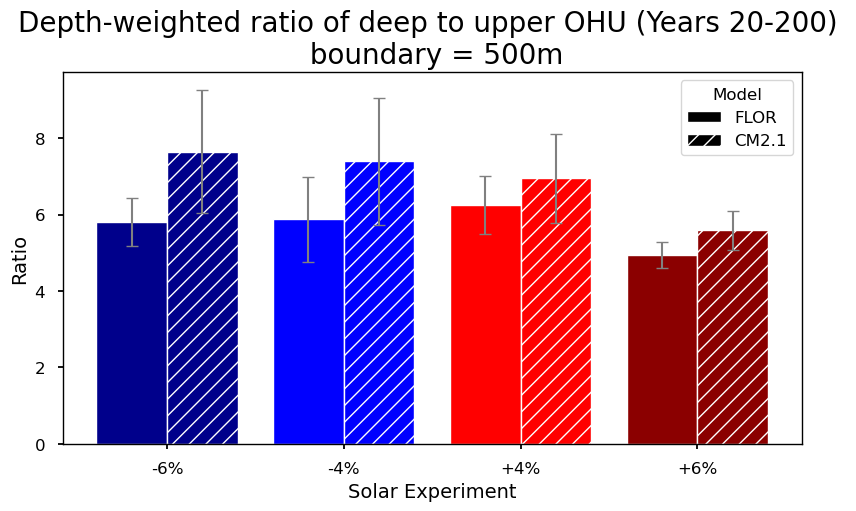

In [15]:
start_year = 20
end_year = 200
boundary = 500

ratio, ratio_error, ts = compute_ratio_all_exp(boundary = boundary, start_year = start_year, end_year = end_year)
barplot_allexp_ratio(ratio, ratio_error)

plt.savefig('Figure3.pdf', bbox_inches='tight', dpi=300)

### try with different boundary

computing...
FLOR
CM2.1
done.
Shown with standard error from timeseries.


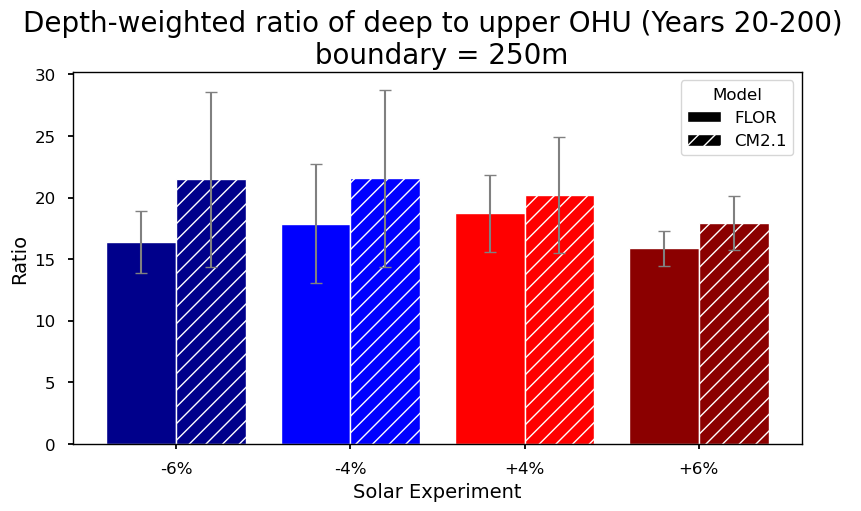

In [12]:
start_year = 20
end_year = 200
boundary = 250

ratio, ratio_error, ts = compute_ratio_all_exp(boundary = boundary, start_year = start_year, end_year = end_year)
barplot_allexp_ratio(ratio, ratio_error)